# Tidal energy conversion in the deep ocean

The inverse model of Egbert and Ray (2000) provides an observational target for the inferred dissipation of the barotropic tide by conversion into baroclinic tides. They estimate that 1±0.25 TW of energy is transfered from the barotropic tide to baroclinic modes **in the deep ocean**. 

In previous model evaluations (e.g. [Adcroft et al. 2019](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS001726)), the global integral of the `TKE_itidal` output has been compared to this 1 TW number. However, a more appropriate comparison would be to only integrate `TKE_itidal` over a comparable deep ocean mask as used by Egbert and Ray; this is what is done in this notebook.

In [52]:
import os
import datetime

In [53]:
config = {
    "startyr": "1958",
    "endyr": "2022",
    "dora_id": "odiv-319, odiv-368", # try with just "odiv-319" as well.
    "pathPP": None,
}

In [54]:
odiv_projects = doralite.list_project("odiv")['project']
OM5_experiments = [e for e in odiv_projects if e['title'] == "OM5 experiments"][0]['experiments']

MAR will pass for environment variables to the script when running via the web engine:

* `MAR_STARTYR`: A `str` of the beginning year of analysis from model
* `MAR_ENDYR`: A `str` of the ending year of analysis from model
* `MAR_DORA_ID`: A `str` of the experiment ID in the database for a single experiment, e.g. `"odiv-1"`, or comma-separated experiments, e.g. `"odiv-1, odiv-2"`
* `MAR_PATHPP`: A `str` of the top-level path to the post-processing experiment directory of the experiment

The block below will use values passed in by Dora but default to the values defined above in `config`. This is useful for interactive usage and debugging.

If executed from Dora, there will also be a `DORA_EXECUTE` variable that is set.

In [55]:
for k, v in config.items():
    if f"MAR_{k.upper()}" in os.environ.keys():
        c = os.environ[f"MAR_{k.upper()}"]
    else:
        c = v
    if k=="dora_id" and (type(v) is not list): 
        c = [e.strip(" ") for e in c.split(",")]
    config[k] = c

In [56]:
import doralite
import glob
import subprocess 

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import ListedColormap, BoundaryNorm

In [57]:
# momgrid will use a directory of pre-computed weights that is used for calculating basic area-weighted statistics later
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

## Define local parameters

In [58]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

def get_local_params(config):
    experiments = {dora_id: doralite.dora_metadata(dora_id) for dora_id in config["dora_id"]}
    params = {
        dora_id: {
            "experiment": experiment,
            "pathPP": experiment["pathPP"],
            "expName": experiment["expName"]
        }
        for dora_id, experiment in experiments.items()
    }
    return params

start = int(config["startyr"])
end = int(config["endyr"])
params = get_local_params(config)

In [59]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_annual"
static = f"{component}/{component}.static.nc"
varname = "TKE_itidal"

chunk = "5yr"

list_of_filelists = [
    glob.glob(f"{p["pathPP"]}{component}/ts/**/{chunk}/{component}.*.{varname}.nc", recursive=True)
    for p in params.values() 
]

In [60]:
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

import itertools
list_of_filelists = [[x for x in filelist if is_in_range(x,start,end)] for filelist in list_of_filelists]
filelist = sorted(list(itertools.chain.from_iterable(list_of_filelists)))

staticfiles = [f"{p["pathPP"]}/{static}" for p in params.values()]

_ = [print(x) for x in filelist]

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual/ts/annual/5yr/ocean_annual.1958-1962.TKE_itidal.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual/ts/annual/5yr/ocean_annual.1963-1967.TKE_itidal.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual/ts/annual/5yr/ocean_annual.1968-1972.TKE_itidal.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual/ts/annual/5yr/ocean_annual.1973-1977.TKE_itidal.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual/ts/annual/5yr/ocean_annual.1978-1982.TKE_itidal.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel2

### DMgetting Files

Dora cannot issue calls to dmget.

In [61]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+filelist+staticfiles
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


In [62]:
models = {}
for odiv, filelist, staticfile in zip(params.keys(), list_of_filelists, staticfiles):

    gds = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True)
    gds.data = gds.data.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))

    og = xr.open_dataset(staticfile)
    og = og.assign_coords({"xh":gds.data.xh, "yh":gds.data.yh})

    models[odiv] = {"gds":gds, "og":og}

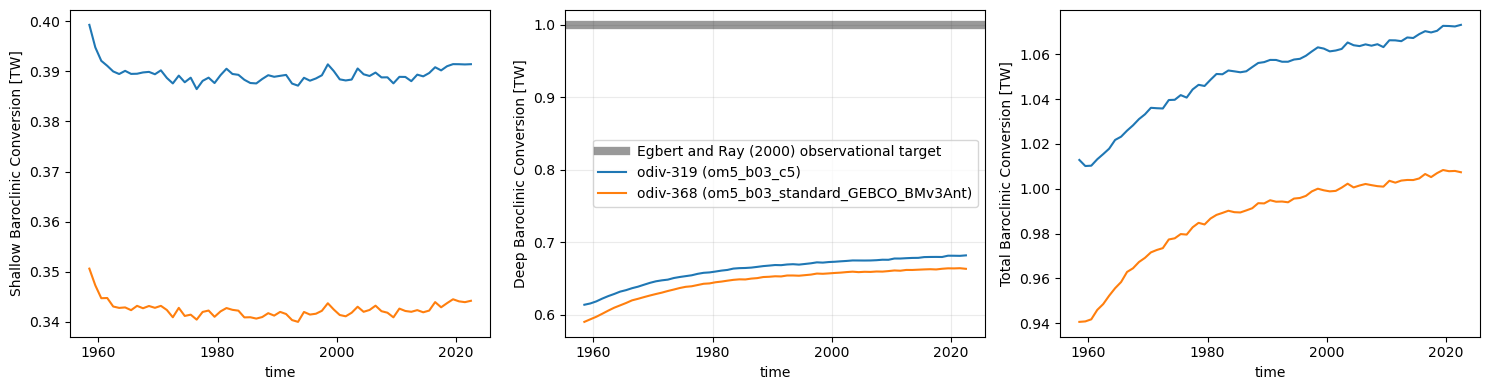

In [64]:
dl = 8
cutoff_depth = 2500

plt.figure(figsize=(15, 4))
plt.subplot(1,3,2)
plt.axhline(1.0, color="k", linewidth=6, alpha=0.4, label="Egbert and Ray (2000) observational target")

for odiv, model in models.items():
    local_tidal_energy_conversion = model["gds"].data.TKE_itidal*model["gds"].data.areacello

    smoothed_depth = model["og"].deptho.fillna(0.).rolling({"xh":dl, "yh":dl}).mean()
    smooth_deep_mask = smoothed_depth.values > cutoff_depth

    global_tidal_energy_conversion = local_tidal_energy_conversion.sum(["xh", "yh"]).compute() * 1e-12
    deep_tidal_energy_conversion = local_tidal_energy_conversion.where(smooth_deep_mask).sum(["xh", "yh"]).compute() * 1e-12
    shallow_tidal_energy_conversion = global_tidal_energy_conversion - deep_tidal_energy_conversion

    plt.subplot(1,3,1)
    shallow_tidal_energy_conversion.plot(label=f"{odiv} ({params[odiv]["expName"]})")
    plt.ylabel("Shallow Baroclinic Conversion [TW]")
    
    plt.subplot(1,3,2)
    deep_tidal_energy_conversion.plot(label=f"{odiv} ({params[odiv]["expName"]})")
    plt.ylabel("Deep Baroclinic Conversion [TW]")
    
    plt.subplot(1,3,3)
    global_tidal_energy_conversion.plot(label=f"{odiv} ({params[odiv]["expName"]})")
    plt.ylabel("Total Baroclinic Conversion [TW]")

plt.subplot(1,3,2)
plt.legend()
plt.tight_layout()
plt.grid(True, alpha=0.25)